### Import libraries and define node class

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets
import random
import statistics

class ZollmanNode:
    def __init__(self, beliefProb, pEH=None):
        self.beliefProb = beliefProb
        self.pEH = pEH

In [67]:
# Create a random graph
globalVar = 10
graph = nx.erdos_renyi_graph(10, 0.3)


# Define the function for one timestep
def testing(graph, parameter):
    # Update the graph based on the parameter
    # This is a placeholder function, you should replace it with your own logic
    print(graph, parameter)
    pass

# Define a function to update the graph based on the parameter value
def update_graph(p1, parameter):
    testing(graph, parameter)
    nx.draw(graph, with_labels=True)
    plt.show()



### Define Function to Display Graph

### Define graph initialization function

In [68]:
def initialize_graph(graphType: str, numNodes: int = 10):
    graph = nx.Graph()
    if graphType == 'circle':
        for index in range(numNodes):
            initial_data = {'group': index % 4, 'beliefProb': random.random(), 'pEH': None}
            graph.add_node(f"scientist-{index}", **initial_data)
            if index > 0:
                graph.add_edge(f"scientist-{index - 1}", f"scientist-{index}")
        graph.add_edge(f"scientist-{numNodes - 1}", "scientist-0")
    elif graphType == 'wheel':
        for index in range(numNodes - 1):
            initial_data = {'group': index % 4, 'beliefProb': random.random(), 'pEH': None}
            graph.add_node(f"scientist-{index}", **initial_data)
            if index > 0:
                graph.add_edge(f"scientist-{index - 1}", f"scientist-{index}")
        graph.add_edge(f"scientist-{numNodes - 2}", "scientist-0")
        graph.add_node(f"scientist-{numNodes - 1}", group=1, beliefProb=random.random(), pEH=None)
        for node in graph.nodes:
            if node != f"scientist-{numNodes - 1}":
                graph.add_edge(node, f"scientist-{numNodes - 1}")
    else:
        for index in range(numNodes):
            initial_data = {'group': index % 4, 'beliefProb': random.random(), 'pEH': None}
            graph.add_node(f"scientist-{index}", **initial_data)
        for i in range(numNodes):
            for j in range(i + 1, numNodes):
                if i != j:
                    graph.add_edge(f"scientist-{i}", f"scientist-{j}")
    return graph

### Define timestep function and helper functions

In [69]:
def run_experiment(world):
    return random.uniform(0.3, 0.8) if world == 'higher' else random.uniform(0.2, 0.7)

def calculate_posterior(pH, pEH):
    pE = pEH * pH + (1 - pEH) * (1 - pH)
    return (pEH * pH) / pE

def timestep(graph):
    nodes = graph.nodes(data=True)
    for node, data in nodes:
        data['pEH'] = run_experiment('higher') if data['beliefProb'] > 0.5 else None
        data['beliefProb'] = calculate_posterior(data['beliefProb'], data['pEH']) if data['pEH'] is not None else data['beliefProb']

    posteriors = []
    for node, data in nodes:
        neighbors = graph.neighbors(node)
        for neighbor in neighbors:
            neighbor_data = graph.nodes[neighbor]
            if neighbor_data['pEH'] is not None:
                data['beliefProb'] = calculate_posterior(data['beliefProb'], neighbor_data['pEH'])
        data['group'] = sum(data['beliefProb'] > x for x in [0, 0.4, 0.6, 1])
        posteriors.append(data['beliefProb'])
    return posteriors

### Define Function to Run Simulation

In [70]:
def run_simulation(graph, num_timesteps=1):
    median_posteriors = []
    for _ in range(num_timesteps):
        posteriors = timestep(graph)
        median_posterior = statistics.median(posteriors)
        median_posteriors.append(median_posterior if median_posterior is not None else 0)
        yield median_posteriors

### Run Simulation and Display Results

Button(description='Initialize Graph', style=ButtonStyle())

Button(description='Run Simulation', disabled=True, style=ButtonStyle())

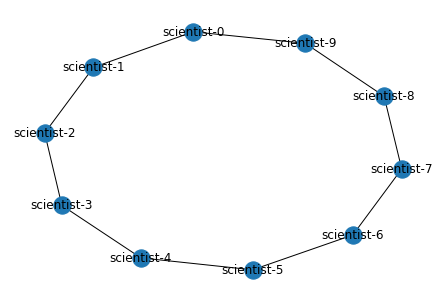

In [73]:
# Define Parameters
numTimesteps = 100 # or do not need this? Just run at a pace
newGraph = nx.Graph()
numNodes_label = widgets.Label("Number of Nodes:")
numNodes = widgets.BoundedIntText(value=10, min=2, max=25, step=1)
graphType = widgets.Select(options=['circle', 'wheel', 'complete'], value='circle', description='Graph Type:')
custom_button = widgets.Button(description="Initialize Graph")
# Group the interactive widgets together using HBox or VBox
widget_group = widgets.VBox([numNodes_label, numNodes, graphType])

# Define timestep
timestepLabel = widgets.Label("Number of Timesteps:")
numTimesteps = widgets.BoundedIntText(value=100, min=1, max=10000, step=1)
timestepGroup = widgets.VBox([timestepLabel, numTimesteps])
start_button = widgets.Button(description="Run Simulation", disabled=True)

def onClick(_):
    initializedGraph = initialize_graph(numNodes=numNodes.value, graphType=graphType.value)
    newGraph.clear()
    newGraph.add_nodes_from(initializedGraph.nodes(data=True))
    newGraph.add_edges_from(initializedGraph.edges(data=True))
    start_button.disabled = False

custom_button.on_click(onClick)

def onStart(_):
    if newGraph.number_of_nodes() < 1:
        ValueError("No Graph initialized")
    run_simulation(graph=newGraph, num_timesteps=numTimesteps.value)
    nx.draw(newGraph, with_labels=True)
    plt.show()
start_button.on_click(onStart)

# Display the custom button and the interactive widgets
display(widget_group, custom_button, timestepGroup, start_button)

In [74]:
# Example usage:
graph = initialize_graph('circle', numNodes=10)
run_simulation(graph, num_timesteps=5)

<generator object run_simulation at 0x11dec0e40>